In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

d:\python\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
ACTIVATION = tf.nn.relu
N_LAYERS = 7
N_HIDDEN_UNITS = 30

In [3]:
##重复观看同一个东西的功能
def fix_seed(seed=1):
    # reproducible
    np.random.seed(seed)
    tf.set_random_seed(seed)   

In [4]:
##观看图，那种很形象的柱状图
def plot_his(inputs,inputs_norm):
    # plot histogram for the inputs of every layer
    for j, all_inputs in enumerate([inputs, inputs_norm]):
        for i, input in enumerate(all_inputs):
            plt.subplot(2, len(all_inputs), j*len(all_inputs)+(i+1))
            plt.cla()
            if i == 0:
                the_range = (-7, 10)
            else:
                the_range = (-1, 1)
            plt.hist(input.ravel(), bins=15, range=the_range, color='#FF5733')
            plt.yticks(())
            if j == 1:
                plt.xticks(the_range)
            else:
                plt.xticks(())
            ax = plt.gca()
            ax.spines['right'].set_color('none')
            ax.spines['top'].set_color('none')
        plt.title("%s normalizing" % ("Without" if j == 0 else "With"))
    plt.draw()
    plt.pause(0.01)    

In [9]:
##建立网络
def built_net(xs, ys, norm):
    def add_layer(inputs, in_size, out_size, activation_function=None, norm=False):
        # weights and biases (bad initialization for this case)
        Weights = tf.Variable(tf.random_normal([in_size, out_size], mean=0., stddev=1.))
        biases = tf.Variable(tf.zeros([1, out_size]) + 0.1)
        # fully connected product
        Wx_plus_b = tf.matmul(inputs, Weights) + biases

        # normalize fully connected product BN的操作过程（有没有都可以）
    
        if norm:
            # Batch Normalize
            fc_mean, fc_var = tf.nn.moments(
                Wx_plus_b,
                axes=[0],   # the dimension you wanna normalize, here [0] for batch
                            # for image, you wanna do [0, 1, 2] for [batch, height, width] but not channel
            )
            scale = tf.Variable(tf.ones([out_size]))
            shift = tf.Variable(tf.zeros([out_size]))
            epsilon = 0.001
            '''
             # apply moving average for mean and var when train on batch
            ema = tf.train.ExponentialMovingAverage(decay=0.5)
            def mean_var_with_update():
                ema_apply_op = ema.apply([fc_mean, fc_var])
                with tf.control_dependencies([ema_apply_op]):
                    return tf.identity(fc_mean), tf.identity(fc_var)
            mean, var = mean_var_with_update()
            '''
           
            #Wx_plus_b = tf.nn.batch_normalization(Wx_plus_b, mean, var, shift, scale, epsilon)
            Wx_plus_b = tf.nn.batch_normalization(Wx_plus_b, fc_mean, fc_var, shift, scale, epsilon)
            # similar with this two steps:
            # Wx_plus_b = (Wx_plus_b - fc_mean) / tf.sqrt(fc_var + 0.001)
            # Wx_plus_b = Wx_plus_b * scale + shift

        # activation
        if activation_function is None:
            outputs = Wx_plus_b
        else:
            outputs = activation_function(Wx_plus_b)
        return outputs
 
    fix_seed(1)
    ##对网络的输入进行BN操作
    if norm:
        # BN for the first input
        fc_mean, fc_var = tf.nn.moments(xs,axes=[0])
        scale = tf.Variable(tf.ones([1]))
        shift = tf.Variable(tf.zeros([1]))
        epsilon = 0.001
        '''
         # apply moving average for mean and var when train on batch
        ema = tf.train.ExponentialMovingAverage(decay=0.5)
        def mean_var_with_update():
            ema_apply_op = ema.apply([fc_mean, fc_var])
            with tf.control_dependencies([ema_apply_op]):
                return tf.identity(fc_mean), tf.identity(fc_var)
        mean, var = mean_var_with_update()
        '''
       
        
        #xs = tf.nn.batch_normalization(xs, mean, var, shift, scale, epsilon)
        xs = tf.nn.batch_normalization(xs, fc_mean, fc_var, shift, scale, epsilon)
    # record inputs for every layer，这个怎么记录的？？
    layers_inputs = [xs]

    # build hidden layers
    for l_n in range(N_LAYERS):
        layer_input = layers_inputs[l_n]
        in_size = layers_inputs[l_n].get_shape()[1].value

        output = add_layer(
            layer_input,    # input
            in_size,        # input size
            N_HIDDEN_UNITS, # output size
            ACTIVATION,     # activation function
            norm,           # normalize before activation
        )

        layers_inputs.append(output)    # add output for next run

    # build output layer
    prediction = add_layer(layers_inputs[-1], 30, 1, activation_function=None)  ##这里的-1是什么意思？？
    cost = tf.reduce_mean(tf.reduce_sum(tf.square(ys - prediction), reduction_indices=[1]))
    train_op = tf.train.GradientDescentOptimizer(0.001).minimize(cost)
    return [train_op, cost, layers_inputs]

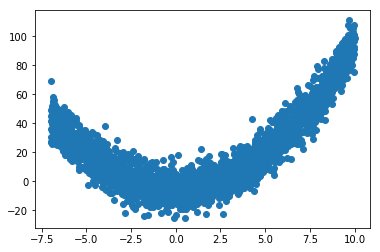

In [10]:
##make up data
fix_seed(1)
x_data = np.linspace(-7, 10, 2500)[:, np.newaxis]
np.random.shuffle(x_data)
noise = np.random.normal(0, 8, x_data.shape)
y_data = np.square(x_data) - 5 + noise
# plot input data
plt.scatter(x_data, y_data)
plt.show()

In [11]:
##建立图模型，搭建两个神经网络, 一个没有 BN, 一个有 BN:
xs = tf.placeholder(tf.float32, [None, 1])  # [num_samples, num_features]
ys = tf.placeholder(tf.float32, [None, 1])

train_op, cost, layers_inputs = built_net(xs, ys, norm=False)   # without BN
train_op_norm, cost_norm, layers_inputs_norm = built_net(xs, ys, norm=True) # with BN

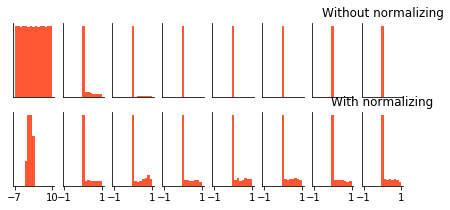

d:\python\lib\site-packages\numpy\lib\function_base.py:780: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
d:\python\lib\site-packages\numpy\lib\function_base.py:781: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


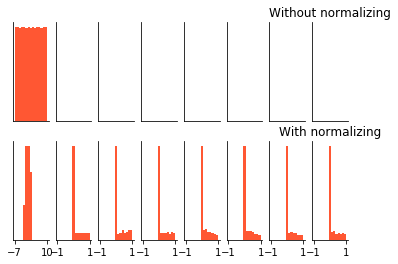

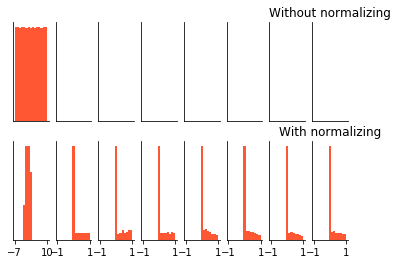

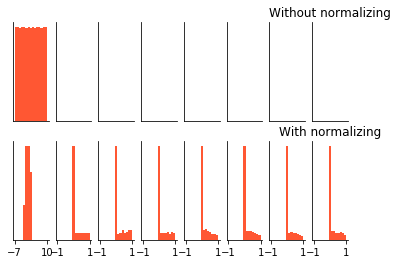

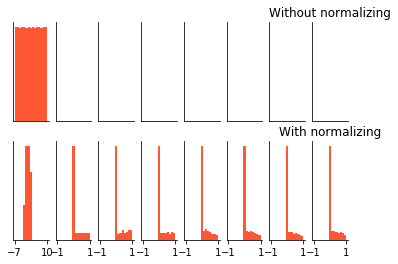

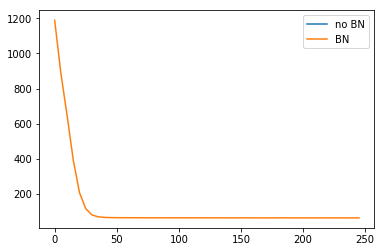

In [12]:
##会话
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)
# record cost
cost_his = []
cost_his_norm = []
record_step = 5
plt.ion()  ##打开交互模式
plt.figure(figsize=(7, 3))
for i in range(250):
    if i % 50 == 0:
        # plot histogram
        all_inputs, all_inputs_norm = sess.run([layers_inputs, layers_inputs_norm], feed_dict={xs: x_data, ys: y_data})
        plot_his(all_inputs, all_inputs_norm)

    # train on batch
    #sess.run([train_op, train_op_norm], feed_dict={xs: x_data[i*10:i*10+10], ys: y_data[i*10:i*10+10]})
    sess.run([train_op, train_op_norm], feed_dict={xs: x_data, ys: y_data})
    if i % record_step == 0:
        # record cost
        cost_his.append(sess.run(cost, feed_dict={xs: x_data, ys: y_data}))
        cost_his_norm.append(sess.run(cost_norm, feed_dict={xs: x_data, ys: y_data}))
##画出误差值的方法
plt.ioff()  #关闭交互模式
plt.figure()
plt.plot(np.arange(len(cost_his))*record_step, np.array(cost_his), label='no BN')     # no norm
plt.plot(np.arange(len(cost_his))*record_step, np.array(cost_his_norm), label='BN')   # norm
plt.legend()
plt.show()